# Regression for the Prime Counting Function

This notebook shows explicit derivations up to **linearization** for two models, then fits them to user-provided data for $x$ and $\pi(x)$.

**Models**:

1. Model (i): $y = A + B\frac{x}{\log x}$.

2. Model (ii): $y = \dfrac{x}{A + B\log x}$ (nonlinear; linearized via reciprocals to get a linear regression in $A,B$).


## Enter Data
Edit the arrays below ("x_list" and "pi_list"). Default values are $x = [10,10^2,10^3,10^4]$ and $\pi(x) = [4,25,168,1229]$.

In [3]:
import numpy as np, math
# --- User input ---
x_list = [10, 100, 1000, 10000]     # edit this list
pi_list = [4, 25, 168, 1229]    
print("x_list:", x_list)
print("pi_list:", pi_list)        
x = np.array(x_list, dtype=float)
y = np.array(pi_list, dtype=float)
assert np.all(x>1) and np.all(y>0), 'Require x>1 and y>0'
#print(f'n = {n}, x = {x}, pi(x) = {y}')


x_list: [10, 100, 1000, 10000]
pi_list: [4, 25, 168, 1229]


## Fit Model (i): $y = A + B\,\dfrac{x}{\log x}$
Closed-form least squares using the normal equations.

## Derivation - Model (i):  $y = A + B\,\dfrac{x}{\log x}$

Let $z_i = \dfrac{x_i}{\log x_i}$. The model becomes $y_i = A + B z_i$.

We seek $A,B$ minimizing the least-squares objective $S(A,B) = \sum_{i=1}^n (y_i - A - B z_i)^2$.

Set partial derivatives to zero (normal equations):\
$\displaystyle \frac{\partial S}{\partial A} = -2\sum_{i=1}^n (y_i - A - B z_i) = 0, \quad \frac{\partial S}{\partial B} = -2\sum_{i=1}^n z_i (y_i - A - B z_i) = 0.$

This yields the linear system\
$\begin{bmatrix} n & \sum z_i \\ \sum z_i & \sum z_i^2 \end{bmatrix} \begin{bmatrix} A \\ B \end{bmatrix} = \begin{bmatrix} \sum y_i \\ \sum z_i y_i \end{bmatrix}.$

Solving the above system of equations gives $A$ and $B$.

<br><br>

In [4]:
# Build regressor z = x/log x
z = x/np.log(x)
n = len(x)
Sz, Sy = z.sum(), y.sum()
Sz2 = (z*z).sum()
Szy = (z*y).sum()
Den = n*Sz2 - Sz*Sz
A1 = (Sy*Sz2 - Sz*Szy) / Den
B1 = (n*Szy - Sz*Sy) / Den
print(f'Model (i) parameters: A = {A1:.6f}, B = {B1:.6f}')
y_pred = A1 + B1*z
lse = ((y - y_pred)**2).sum()
print(f"Least squares error = {lse:.6f}")

Model (i) parameters: A = 1.119580, B = 1.131282
Least squares error = 14.431526


In [5]:
# Example prediction at x = 10^5
x_new = 10**5
z_new = x_new / np.log(x_new)
y_pred_new = A1 + B1 * z_new
print(f"Prediction: pi({x_new}) ≈ {y_pred_new:.2f}")

Prediction: pi(100000) ≈ 9827.31


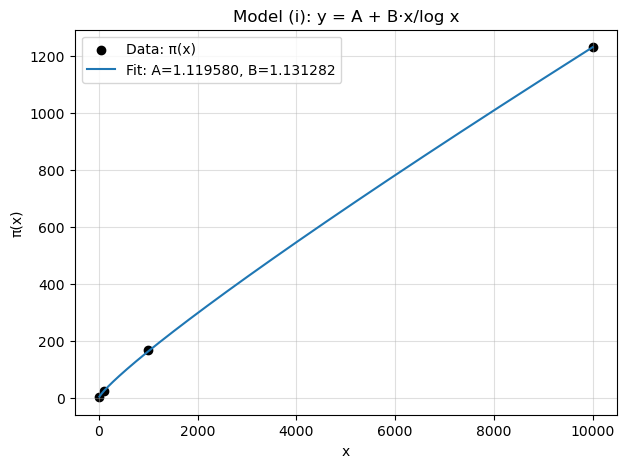

In [6]:
# Plot for Model (i)
import matplotlib.pyplot as plt
xplot = np.linspace(min(x), max(x), 500)
yhat1 = A1 + B1*(xplot/np.log(xplot))
plt.figure(figsize=(7,5))
plt.scatter(x, y, color='black', label='Data: π(x)')
plt.plot(xplot, yhat1, color='tab:blue', label=f'Fit: A={A1:.6f}, B={B1:.6f}')
plt.xlabel('x')
plt.ylabel('π(x)')
plt.title('Model (i): y = A + B·x/log x')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


## Fit Model (ii) via Linearization: $y = \dfrac{x}{A \log x + B}$


Linearize the model: $\pi(x) \approx \dfrac{x}{A\log x + B}$ becomes **linear** if we set $y = x/\pi(x)$ and $t = \ln x$, giving $y \approx A t + B$.




In [7]:
import numpy as np

def legendre_fit_linearized(xs, pis):
    """
    Fit A, B in x/pi(x) ≈ A ln x + B by OLS on (ln x, x/pi(x)),
    using the explicit normal-equation solution:
        beta = (X^T X)^(-1) (X^T y).
    
    Also computes:
      - least-squares error (RSS) in the linearized space y vs A ln x + B,
      - actual errors for the prime counting function on the same x:
          abs_err[i] = pi_hat(x_i) - pi(x_i)
          rel_err[i] = abs_err[i] / pi(x_i)

    Parameters
    ----------
    xs : array-like
        x values (e.g., [10, 100, 1000, 10000]).
    pis : array-like
        corresponding pi(x) values (e.g., [4, 25, 168, 1229]).

    Returns
    -------
    A : float
    B : float
    ls_rss : float
        Residual sum of squares in the linearized fit (y vs A ln x + B).
    pi_abs_err : np.ndarray
        Absolute errors for pi(x): pi_hat(x) - pi_true(x), for the filtered points.
    pi_rel_err : np.ndarray
        Relative errors for pi(x): (pi_hat - pi_true) / pi_true, for the filtered points.

    Notes
    -----
    - Only points with x >= 3 and pi(x) > 0 are used (to avoid log/division issues).
    - The order of error arrays corresponds to the filtered xs.
    - For numerical robustness, QR/SVD or `np.linalg.solve` are preferred in general,
      but here we use the explicit inverse as requested.
    """
    # Convert inputs to 1D float arrays (so Python lists work too)
    xs = np.asarray(xs, dtype=float).ravel()
    pis = np.asarray(pis, dtype=float).ravel()

    if xs.shape != pis.shape:
        raise ValueError(f"xs and pis must have the same shape; got {xs.shape} vs {pis.shape}")

    # Filter valid points
    mask = (xs >= 3) & (pis > 0)
    if mask.sum() < 2:
        raise ValueError("Need at least two valid points with x >= 3 and pi(x) > 0.")

    x = xs[mask]
    pi_true = pis[mask]
    t = np.log(x)
    y = x / pi_true

    # Design matrix: columns [ln x, 1]
    X = np.column_stack([t, np.ones_like(t)])

    # Explicit normal-equation solution: beta = (X^T X)^(-1) (X^T y)
    XtX = X.T @ X
    Xty = X.T @ y

    # Optional: warn if ill-conditioned (we proceed with inverse as requested)
    cond = np.linalg.cond(XtX)
    if not np.isfinite(cond):
        raise np.linalg.LinAlgError("X^T X is singular or not finite.")
    # Proceed with explicit inverse
    beta = np.linalg.inv(XtX) @ Xty

    A, B = float(beta[0]), float(beta[1])

    # Least-squares error (RSS) in the linearized space
    y_hat = X @ beta
    resid = y - y_hat
    ls_rss = float(np.sum(resid**2))

    # Actual errors for pi(x): compare pi_hat(x) vs pi_true(x)
    denom = A * t + B
    pi_hat = x / denom
    pi_abs_err = pi_hat - pi_true
    actual_error = float(np.sum(pi_abs_err**2))
    

    return A, B, ls_rss, actual_error


In [8]:
xs = [10, 100, 1000, 10000]     # edit this list
pis = [4, 25, 168, 1229]  


A, B, ls_rss, actual_error = legendre_fit_linearized(xs, pis)
print("A=",A," B=",B)
print("Least squares error: ",ls_rss)
print("Actual error: ",actual_error)

A= 0.8191866834122363  B= 0.43165174938974715
Least squares error:  0.1195017723878664
Actual error:  624.2156614189832


In [9]:
# Example prediction at x = 10^5
x_new = 10**5
t_new = np.log(x_new)
y_pred = A * t_new + B
pi_x_pred = x_new/y_pred
print(f"Prediction: pi({x_new}) ≈ {pi_x_pred:.2f}")

Prediction: pi(100000) ≈ 10139.02
